In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms, utils, datasets, models
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from helper_functions_clean import *

# 1. Introduction and dataset info

This notebook explores how convoluational neural nets (CNNs) misclassify outlier and/or minority images not present in training sets. Motivating examples include the performance of self-driving cars under [extreme](https://www.theguardian.com/technology/2018/mar/22/self-driving-car-uber-death-woman-failure-fatal-crash-arizona
) or [adversarial](https://www.bleepingcomputer.com/news/security/you-can-trick-self-driving-cars-by-defacing-street-signs/) conditions, and search engine [bias against identity groups](https://qz.com/1064035/google-goog-explains-how-artificial-intelligence-becomes-biased-against-women-and-minorities/). A CNN is trained on a dataset with well-defined classes. Minority image types are reliably misclassified by the net. Remedial training strategies are explored and shown to be effective at combating this type of misclassification problem.

"Rock", "Paper", and "Scissor" are chosen as base classes. Approximately 700 images from each class were scraped from Yahoo! image search (NB even with a sophisticated scraper, Google image search is limited to ~400 results). A train-validation split was applied, allocating 100 images from each class to the validation set. 

The first 5 images from each class are displayed. Most images are between 150 and 400 pixels in dimension, and not necessarily square. The *dataloader* class crops and resizes images to 224x224 pixels. To reduce overfitting, training images are also rotated +/- 10 degrees and horizontally flipped at random.

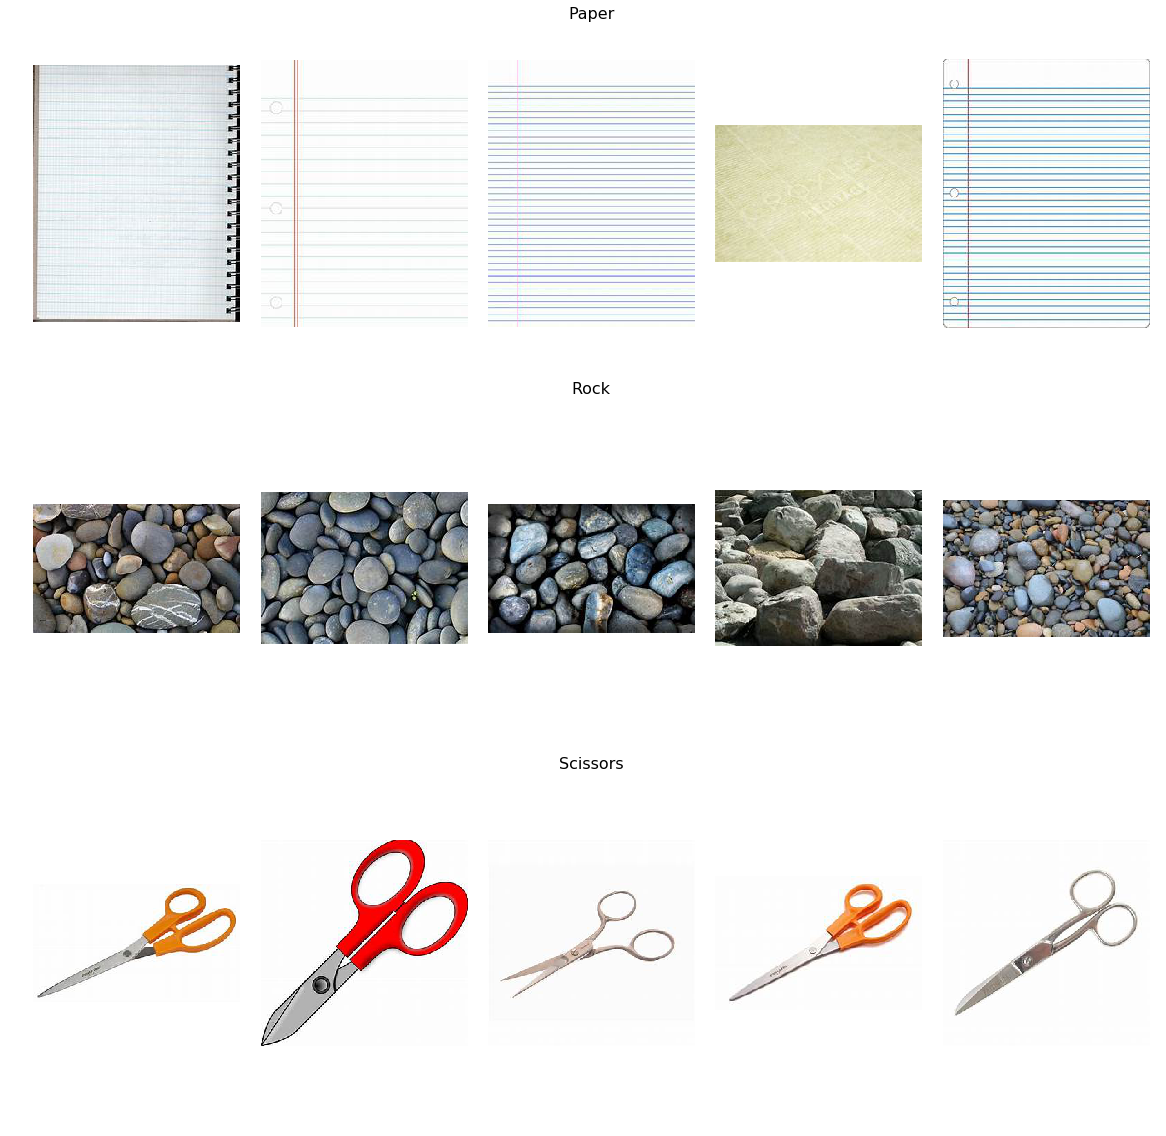

In [2]:
data_dir = 'data/rps/'
class_names, dataloaders = get_data_loaders_init(data_dir)
trainloader = dataloaders['train']
validloader = dataloaders['valid']

plot_training_data(data_dir)

# 2. Network construction

A basic CNN is constructed using torch modules. Images are expected to be of shape 224x224 with 3 channels (RGB). They are fed through two convolutional layers of kernal size 5, with a rectified linear unit [(ReLU)](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) and [max pooling](https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks) applied after each convolution. The convolutional layers have 7 and 16 output channels respectively.

After convolution, three fully connected [linear layers](http://pytorch.org/docs/master/nn.html#torch.nn.Linear) progressively reduce the dimensionality of the feed, until a [softmax](http://pytorch.org/docs/master/nn.html#torch.nn.Softmax) is applied to estimate the probability of class membership.

In [3]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)
        #self.sm = nn.LogSoftmax()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1)
       # x = self.sm(x)
        return x


net = Net(len(class_names))
net.cuda() # the cuda method puts the net on the GPU. An nVidia GPU with the appropriate drivers is required.

Net(
  (conv1): Conv2d(3, 7, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(7, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

## 3. Network training and validation

Initially, the net weights are random, but can still be used to classify images. Each batch of images is classified, and the prediction error is back-propogated to adjust network weights using stochastic gradient descent. This process repeats until validation loss stops improving. Typically, validation loss plateaus after about 75 epochs.

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
training_stats = []

for epoch in range(75):
    
    running_loss = 0.0
    valid_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
    
    for j, data in enumerate(validloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss.data[0]
        
    training_stats.append(get_net_accuracy_stats(dataloaders, net, epoch))
    print('epoch: %d, train loss: %.3f, valid loss: %.3f' % (epoch + 1, running_loss/(trainloader.batch_size*i), valid_loss/(validloader.batch_size*j)))

print('Finished Training')

epoch: 1, train loss: 0.217, valid loss: 0.180
epoch: 2, train loss: 0.191, valid loss: 0.174
epoch: 3, train loss: 0.175, valid loss: 0.146
epoch: 4, train loss: 0.173, valid loss: 0.141
epoch: 5, train loss: 0.163, valid loss: 0.170
epoch: 6, train loss: 0.156, valid loss: 0.123
epoch: 7, train loss: 0.157, valid loss: 0.143
epoch: 8, train loss: 0.155, valid loss: 0.118
epoch: 9, train loss: 0.149, valid loss: 0.123
epoch: 10, train loss: 0.143, valid loss: 0.131
epoch: 11, train loss: 0.142, valid loss: 0.195
epoch: 12, train loss: 0.151, valid loss: 0.126
epoch: 13, train loss: 0.144, valid loss: 0.170
epoch: 14, train loss: 0.138, valid loss: 0.114
epoch: 15, train loss: 0.133, valid loss: 0.107
epoch: 16, train loss: 0.127, valid loss: 0.111
epoch: 17, train loss: 0.134, valid loss: 0.135
epoch: 18, train loss: 0.128, valid loss: 0.110
epoch: 19, train loss: 0.128, valid loss: 0.094
epoch: 20, train loss: 0.123, valid loss: 0.124
epoch: 21, train loss: 0.119, valid loss: 0.110
e

A confusion matrix can be used to visualize the predicted vs. actual classifications for the data (validation set). While the net architecture is relatively shallow, it gives reasonably accurate predictions for each class.

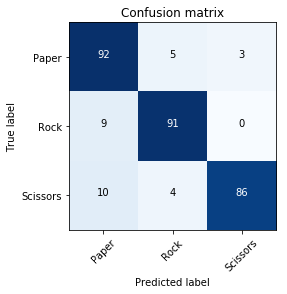

In [5]:
ground_truth, probability_list_base_classes, prediction = prediction_list(validloader, net)
cnf_matrix = confusion_matrix(ground_truth, prediction)
plot_confusion_matrix(cnf_matrix, class_names)

Additionally, individual images can be visualized as they pass through the CNN. After the first layer, the input image will be convolved with 7 different kernals to produce 7 different intermediate images. In general, the more an input "activates" a layer, the stronger the intensity.

Each layer is flagged with the class it most activates in the validation set. Although note that other classes can activate the same layer. For example, most scissors in the training set have a white background, so paper also activates many scissor layers. Paper is still correctly classified by its reduced activation of textured "rock" layers. 

In [6]:
modulelist = list(net.modules())[1:]
valid_path = data_dir + 'valid/' + '{}/'
layer_activation_strength, strongest_activator = layers_by_classification(valid_path, class_names, net, 1)

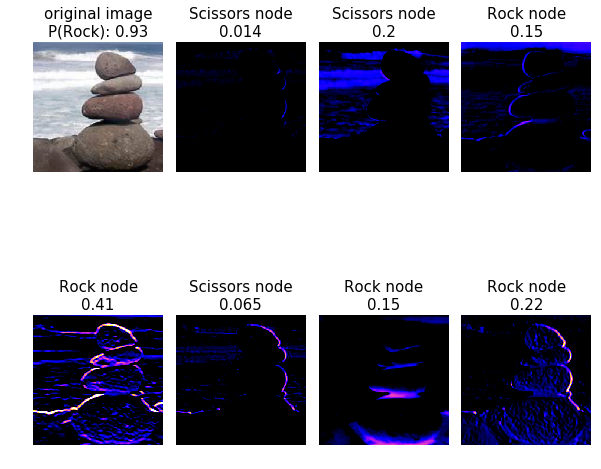

In [7]:
im_path = 'data/rps/valid/Rock/pic_043.jpg'
plot_first_layer_with_strongest_activator(im_path, modulelist[0], strongest_activator, net, class_names)

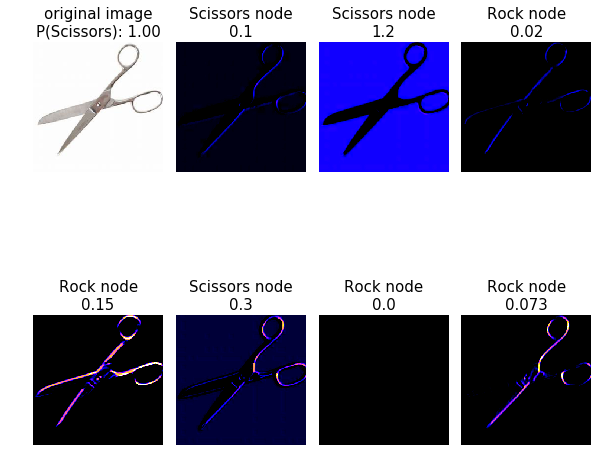

In [8]:
im_path = 'data/rps/valid/Scissors/pic_007.jpg'
plot_first_layer_with_strongest_activator(im_path, modulelist[0], strongest_activator, net, class_names)

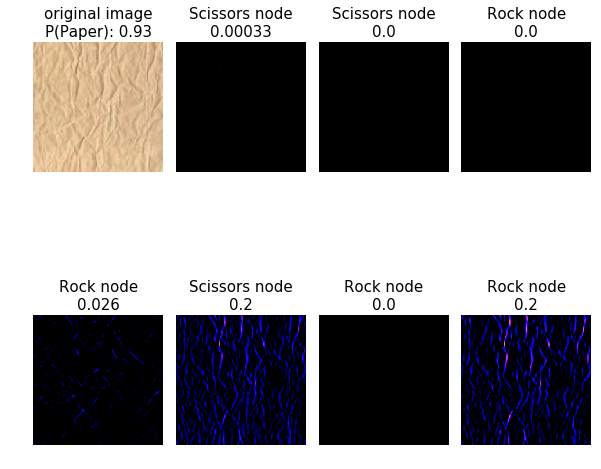

In [9]:
im_path = 'data/rps/valid/Paper/pic_025.jpg'
plot_first_layer_with_strongest_activator(im_path, modulelist[0], strongest_activator, net, class_names)

More examples of predictions from the validation set:

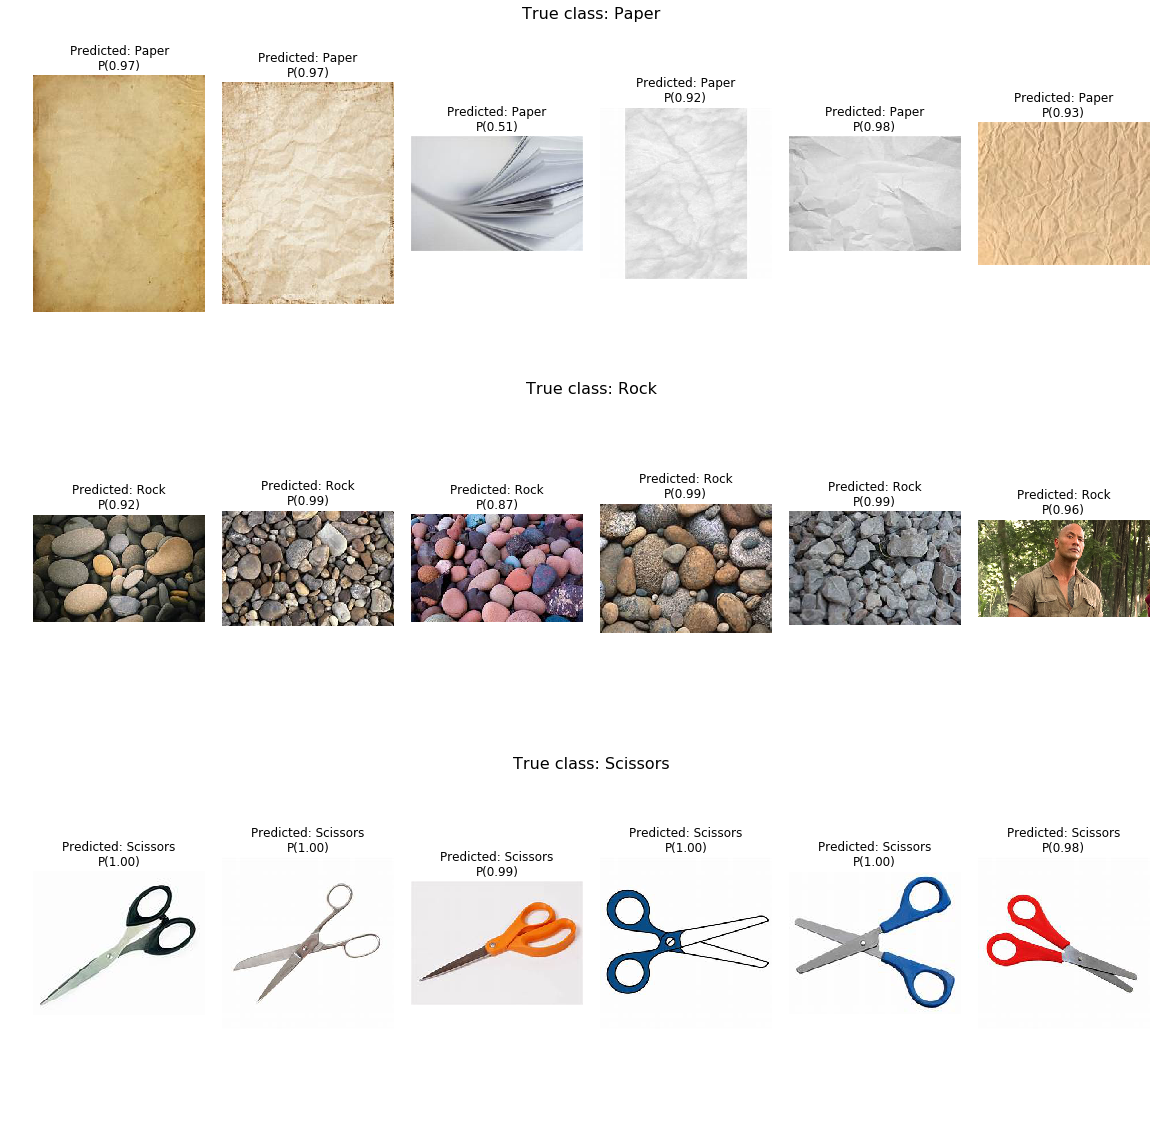

In [10]:
plot_validation_data_with_prediction(data_dir, class_names, net, 6)

## 4. Misclassification of outlier images

*record scratch*

*freeze frame*

You're probably wondering how Dwayne Johnson ended up being classified as a rock...

There is no picture of Dwayne Johnson in our training set, but I did add one to the validation set! It turns out that most pictures of Dwayne Johnson activate the same convolutional layers as real rocks, so having never seen a "Dwayne Johnson", the CNN will "misclassify" The Rock as a rock. 

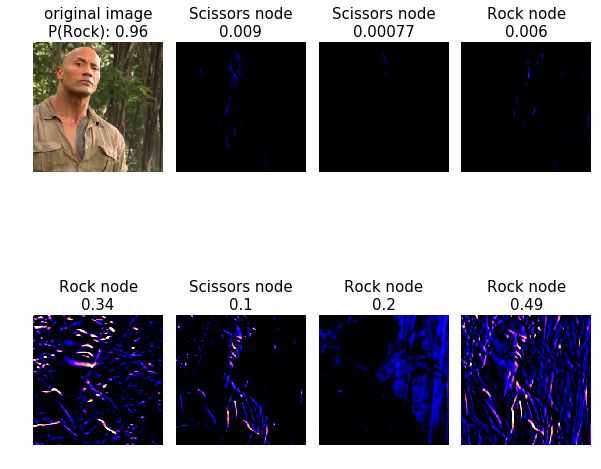

In [11]:
im_path = 'data/rps/valid/Rock/pic_009.jpg'
plot_first_layer_with_strongest_activator(im_path, modulelist[0], strongest_activator, net, class_names)

Is this repeatable? 100 images of Dwayne Johnson were added to the validation set, resulting in the folowing confusion matrix. Over 75 percent were classified as rocks.

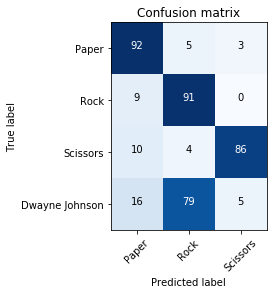

In [12]:
rockloader = dataloaders['dwayne_johnson']
probability_list_dj, prediction_dj = predict_proba_for_hidden_class(rockloader, net)
plot_confusion_matrix_hidden_class(cnf_matrix, class_names, prediction_dj, 'Dwayne Johnson', title='Confusion matrix')

## 5. Solution via confidence thresholding

We should expect Dwayne Johnson to less consistently activate layers trained solely on the base classes. This is reflected in the histogram below, where the probabilities of class membership for Dwayne Johnson are systematically lower compared to rock/paper/scissors.

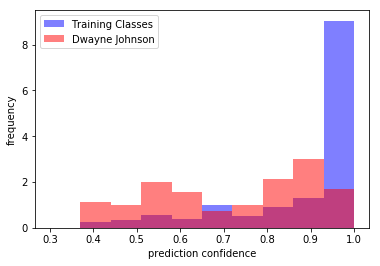

In [13]:
ground_truth, probability_list_base_classes, prediction = prediction_list(validloader, net)
probability_list_dj, prediction_dj = predict_proba_for_hidden_class(rockloader, net)

plt.hist(probability_list_base_classes, density=True, fc = [0,0,1,0.5], range = (0.3,1))
plt.hist(probability_list_dj, density = True, fc = [1, 0, 0, 0.5], range = (0.3,1))
plt.legend(['Training Classes', 'Dwayne Johnson']); plt.ylabel('frequency'); plt.xlabel('prediction confidence'); plt.show()

During training, confidence of prediction was recorded for each class. 

It was hypothesized that as the net layers became more closely trained to the base classes, prediction confidence for Dwayne Johnson would decrease. Instead, there seems to be no trend during training, indicating that in this particular instance, the net layers are agnostic to outlier classes.

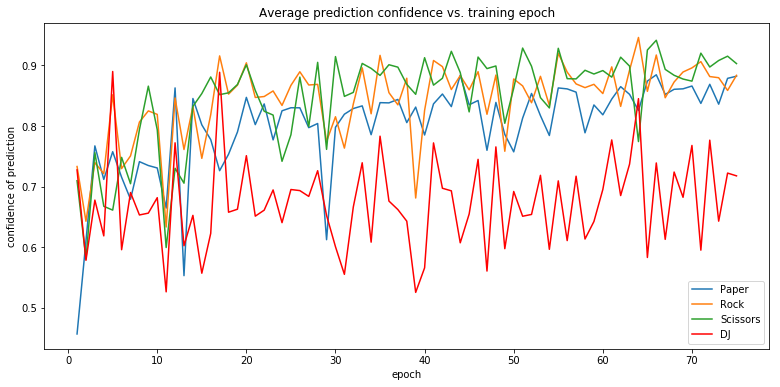

In [14]:
plot_training_stats(training_stats, class_names)

While no trend emerges vs. level of training, these findings suggest that outlier images can be excluded from classification by imposing a threshold for confidence. For example:

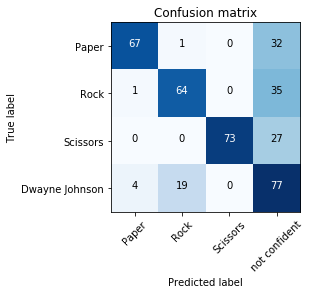

In [15]:
confidence_threshold = 0.9
adjusted_pred_dj = [pred if proba > confidence_threshold else len(class_names) for proba, pred in zip(probability_list_dj, prediction_dj)]
adjusted_pred_base_classes = [pred if proba > confidence_threshold else len(class_names) for proba, pred in zip(probability_list_base_classes, prediction)]
cnf_matrix_adjusted = confusion_matrix(ground_truth, adjusted_pred_base_classes)
hidden_class_confusion = [adjusted_pred_dj.count(i) for i in range(4)]
cnf_matrix_adjusted[-1:] = hidden_class_confusion

plot_confusion_matrix_extra_label(cnf_matrix_adjusted, class_names, 'not confident', 'Dwayne Johnson')

Requiring a higher level of confidence allows a large portion of Dwayne Johnson's images to be flagged as "not confident". Additionally, many predictions for base classes are also below the confidence threshold. This improves the precision of base class predictions, but decreases recall. These tradeoffs are shown below:

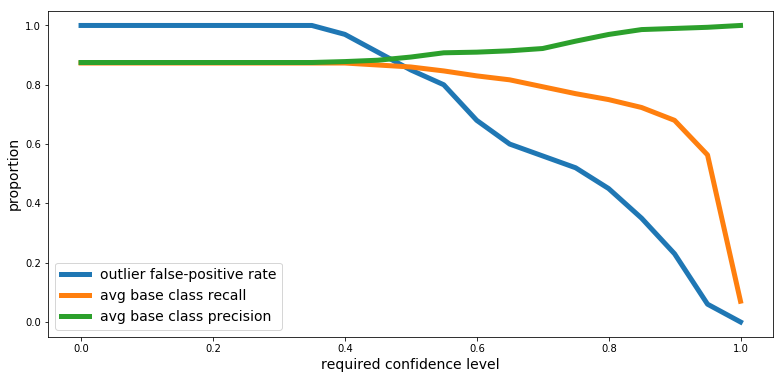

In [16]:
accuracy_vs_confidence_plot(ground_truth, probability_list_base_classes, prediction, probability_list_dj, prediction_dj, class_names)

Unfortunately, while many images of Dwayne Johnson can be excluded from classification by requiring a confidence threshold, about 20% of his images are still classified as rocks with high confidence.

Continued in part 2...